In [59]:
osi_threshold = 0.4
dsi_threshold = 0.3
#tf_for_dsi_calc = 2.0
# ecid = 511510650
# ecid,eid pairs
eids = [(701412138, 704298735),
 (511507650, 501794235),
 (511509529, 500964514),
 (511510718, 510174759),
 (511510855, 509644421),
 (511510718, 510514474),
 (511510736, 501704220),
 (511510670, 502205092),
 (511510650, 501886692),
 (511510670, 504642019),
 (511510736, 501559087),
 (511509529, 501271265),
 (511507650, 500855614),
 (511510650, 501836392),
 (511510855, 510517131),
 (511510736, 501474098),
 (511510855, 510705057),
 (511510718, 510345479),
 (701412138, 705412356),
 (511507650, 502115959),
 (701412138, 704826374),
 (511510650, 501717543),
 (511509529, 501337989),
 (511510670, 502368172)]

# First pairs that I've tried
# [(511510650,501836392), (511510650,501886692), (511510650,501717543)]

# 'VISp', 175, 'Emx1-IRES-Cre', all pairs.
"""
[(543677425, 545446482),
 (517328083, 526928092),
 (517328083, 526504941),
 (536323956, 539515366),
 (536323956, 541048140),
 (536323956, 540684467),
 (543677425, 544507627),
 (543677425, 543677427),
 (517328083, 527583578)]
"""

# 'VISp', 175, 'Cux2-CreERT2', all pairs.
"""
[(701412138, 704298735),
 (511507650, 501794235),
 (511509529, 500964514),
 (511510718, 510174759),
 (511510855, 509644421),
 (511510718, 510514474),
 (511510736, 501704220),
 (511510670, 502205092),
 (511510650, 501886692),
 (511510670, 504642019),
 (511510736, 501559087),
 (511509529, 501271265),
 (511507650, 500855614),
 (511510650, 501836392),
 (511510855, 510517131),
 (511510736, 501474098),
 (511510855, 510705057),
 (511510718, 510345479),
 (701412138, 705412356),
 (511507650, 502115959),
 (701412138, 704826374),
 (511510650, 501717543),
 (511509529, 501337989),
 (511510670, 502368172)]
"""

# 'VISp', 175, 'Cux2-CreERT2'
# [(701412138, 704298735), (701412138, 705412356), (701412138, 704826374)]

# 'VISp', 175, 'Emx1-IRES-Cre'
# [(543677425, 545446482), (543677425, 544507627), (543677425, 543677427)]

# 'VISp', 175, 'Vip-IRES-Cre'
# [(604866830, 605913519), (604866830, 606353987), (604866830, 604866832)]

# 'VISp', 275, 'Cux2-CreERT2'
# [(511510699, 502974807), (511510699, 502810282), (511510699, 502608215)]

# VISp 275 Emx1-IRES-Cre
# [(527676429, 528402271), (527676429, 528693630), (527676429, 528574532)]

# 'VISp', 275, 'Vip-IRES-Cre'
# [(659491615, 663479824), (659491615, 663868423), (659491615, 661771052)]

# 'VISp', 275, 'Sst-IRES-Cre'
# [(601259497, 601259499), (601259497, 601338233), (601259497, 601423209)]

# 'VISp', 375, 'Emx1-IRES-Cre'
# [(545578995, 546716391), (545578995, 546341286), (545578995, 545578997)]

# 'VISp', 375, 'Sst-IRES-Cre'
# [(582621871, 584533518), (582621871, 584196534), (582621871, 583130100)]

# Events or dff
use_events = True
# Only pairs that are closer than these frames will be considered.
# For reference, ko 2011 did 50um. Each 512 pixel field of view is 400 um. 64frames =50um.
max_d = 64
# So we don't cheat and reuse the same cell, since there are some segmentation errors.
# And, to reduce the confound of fluorescence affecting neighbors 
min_d = 5
# corr_type = TEMP_CORR_AVG, AVG_TEMP_CORR, NOISE_CORR
# Ho ko 2011 used TEMP_CORR_AVG for signal correlation.
# "Signal correlation was calculated as the correlation coefficient of the average responses to stimulus."
# Then, NOISE_CORR for noise correlation.
# "Noise correlation was found by subtracting the average response from the responses"
corr_type = 'TEMP_CORR_AVG'

In [60]:
import os
drive_path = '/media/stephen/Brain20191/allen-brain-observatory/visual-coding-2p/'
if not os.path.isdir(drive_path):
    drive_path = '/media/alihamodi/Brain2019/allen-brain-observatory/visual-coding-2p/'

import warnings; warnings.simplefilter('ignore');
from utils.polarplot import *
from utils.polardata import *
from utils.data_wrappers import *
import os
import pandas as pd
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info
manifest_file = os.path.join(drive_path,'manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

import warnings;
warnings.simplefilter('ignore');
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
    
# Outputs = [cell_specimen_id, experiment_container_id, pref_dir]
#pd.DataFrame(boc.get_ophys_experiments(experiment_container_ids=[ecid]))
0

0

In [61]:
def get_dir_pairs_to_corrs_one_exp(boc, cells, ecid, eid):
    print("Processing ecid {}, eid {}".format(ecid, eid))
    dg_response_filter = get_dg_response_filter_from_saskia()
    filtered_cells = get_filtered_cells(cells, dg_response_filter)
    filtered_cells = filtered_cells[filtered_cells.experiment_container_id==ecid]
    data_set = boc.get_ophys_experiment_data(eid)

    # Filter out based on tf-specific-dsi, rather than allen's global dsi
    # Also recalculate preferred direction using specific tf.
    """
    tf_specific_dsi_col = []
    tf_specific_pref_dir_col = []
    for index, row in filtered_cells.iterrows():
        polardata_for_this_cell = get_avg_normalized_response(
            data_set = data_set,
            cell_specimen_id = row.cell_specimen_id,
            temporal_frequency = tf_for_dsi_calc)
        if polardata_for_this_cell is None:
            # Put negative value so dsi selector will ignore this guy.
            new_dsi_cell = -1
        else:
            new_dsi_cell = get_new_dsi(polardata_for_this_cell.to_frame())
        tf_specific_dsi_col.append(new_dsi_cell)
        tf_specific_pref_dir_col.append(polardata_for_this_cell.argmax())
    filtered_cells['tf_specific_dsi'] = tf_specific_dsi_col
    filtered_cells['pref_dir'] = tf_specific_pref_dir_col
    """
    # TODO: recompute this manually at a specific phase.
    filtered_cells['pref_ori'] = filtered_cells['pref_ori_sg'] 
    # Ko 2011 uses both.
    # TODO: recompute the dsi and osi based on a fixed sf and tf
    filtered_cells = filtered_cells[filtered_cells.osi_sg > osi_threshold]
    filtered_cells = filtered_cells[filtered_cells.dsi_dg > dsi_threshold]

    dirs = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0]

    angle_to_cell_groups = {}
    for d in dirs:
        angle_to_cell_groups[d] = filtered_cells[filtered_cells.pref_ori == d].cell_specimen_id.values
        print(d, angle_to_cell_groups[d])

    dir_pairs_to_corrs = {}
    for d1 in dirs:
        for d2 in dirs:
            if len(angle_to_cell_groups[d1]) == 0 or len(angle_to_cell_groups[d2]) == 0:
                continue
            corrs, num_group1, num_group2, best_pair, max_pair_corr = pairwise_dir_avg_temp_corr_one_exp(
                boc, eid,
                angle_to_cell_groups[d1],
                angle_to_cell_groups[d2],
                max_d,
                min_d,
                use_events,
                corr_type)
            if corrs is None:
                continue
            dir_pairs_to_corrs[(d1, d2)] = corrs
            print ("d1", d1,
                   "d2", d2,
                   "num_pairs", len(corrs),
                   "num_group1", num_group1,
                   "num_group2", num_group2,
                   "max corr val, best-pair", max_pair_corr, best_pair,
                "corrs", corrs)
    return dir_pairs_to_corrs

all_dir_pairs_to_corrs = {}
for ecid, eid in eids:
    dir_pairs_to_corrs = get_dir_pairs_to_corrs_one_exp(boc, cells, ecid, eid)
    for dir_pair, corrs in dir_pairs_to_corrs.items():
        if dir_pair not in all_dir_pairs_to_corrs:
            all_dir_pairs_to_corrs[dir_pair] = []
        all_dir_pairs_to_corrs[dir_pair].extend(corrs)

Processing ecid 701412138, eid 704298735
0.0 [729433328 729433925 729434139 729434545 729434571 729435081 729435344
 729435448 729435463]
30.0 [729434030 729434652 729435117]
60.0 [729433884]
90.0 [729433364 729434018]
120.0 [729433843 729433999 729434586 729434637 729434726 729435435]
150.0 [729432524 729433987 729434188]
d1 0.0 d2 0.0 num_pairs 4 num_group1 9 num_group2 9 max corr val, best-pair 0.15059059882636894 (729435344, 729435448) corrs [0.15059059882636894, 0.07856688181145315, 0.15059059882636894, 0.07856688181145315]
d1 0.0 d2 30.0 num_pairs 3 num_group1 9 num_group2 3 max corr val, best-pair 0.22692597866086772 (729434545, 729434030) corrs [0.22692597866086772, 0.0522039496370814, 0.16288963089485375]
d1 0.0 d2 90.0 num_pairs 1 num_group1 9 num_group2 2 max corr val, best-pair -0.05338525517767956 (729433328, 729433364) corrs [-0.05338525517767956]
d1 0.0 d2 120.0 num_pairs 1 num_group1 9 num_group2 6 max corr val, best-pair 0.03837119922826231 (729434545, 729434586) corrs

d1 0.0 d2 120.0 num_pairs 13 num_group1 8 num_group2 15 max corr val, best-pair 0.12501816597420745 (587179626, 587178390) corrs [-0.04127411471153637, 0.009392575907815027, -0.023382813812967137, 0.03327963326446069, -0.0049425961415200895, -0.05658744932837994, -0.005248167040535766, 0.0027920895728263833, 0.06744633565869848, 0.03525097532468865, 0.0030346848219472114, -0.04318711080904331, 0.12501816597420745]
d1 0.0 d2 150.0 num_pairs 4 num_group1 8 num_group2 8 max corr val, best-pair 0.11910507700160974 (517409883, 517409566) corrs [-0.04624268488254677, -0.06802507597739872, 0.09328913066447726, 0.11910507700160974]
d1 30.0 d2 0.0 num_pairs 1 num_group1 6 num_group2 8 max corr val, best-pair -0.025305309405158277 (517409789, 517409347) corrs [-0.025305309405158277]
d1 30.0 d2 60.0 num_pairs 3 num_group1 6 num_group2 7 max corr val, best-pair 0.07068808715836011 (587178712, 517409115) corrs [0.004215424788391599, 0.06891901883470082, 0.07068808715836011]
d1 30.0 d2 90.0 num_pair

d1 120.0 d2 30.0 num_pairs 2 num_group1 7 num_group2 6 max corr val, best-pair 0.029682773922282142 (517425010, 517426438) corrs [-0.04542792519577274, 0.029682773922282142]
d1 120.0 d2 120.0 num_pairs 2 num_group1 7 num_group2 7 max corr val, best-pair -0.059565872986643 (517422876, 517427492) corrs [-0.059565872986643, -0.059565872986643]
d1 120.0 d2 150.0 num_pairs 1 num_group1 7 num_group2 4 max corr val, best-pair -0.018243058442968547 (517424117, 517426420) corrs [-0.018243058442968547]
d1 150.0 d2 60.0 num_pairs 1 num_group1 4 num_group2 2 max corr val, best-pair 0.4379262105192805 (517422775, 517422760) corrs [0.4379262105192805]
d1 150.0 d2 120.0 num_pairs 1 num_group1 4 num_group2 7 max corr val, best-pair -0.018243058442968547 (517426420, 517424117) corrs [-0.018243058442968547]
Processing ecid 511510855, eid 509644421
0.0 [517511174 517512409 517513209 517514206 517514470 517514711 517514929
 517514947 588898408]
30.0 [517509371 517511156 517511581 517511728 517513114 51751

d1 90.0 d2 90.0 num_pairs 2 num_group1 7 num_group2 7 max corr val, best-pair -0.04824687674966222 (517422732, 517426962) corrs [-0.04824687674966222, -0.04824687674966222]
d1 90.0 d2 120.0 num_pairs 1 num_group1 7 num_group2 7 max corr val, best-pair 0.18371266324077495 (517426962, 517423356) corrs [0.18371266324077495]
d1 120.0 d2 30.0 num_pairs 3 num_group1 7 num_group2 6 max corr val, best-pair 0.042598631413953855 (517422876, 517423012) corrs [0.012992598116600905, 0.042598631413953855, 0.01619722876098617]
d1 120.0 d2 90.0 num_pairs 1 num_group1 7 num_group2 7 max corr val, best-pair 0.18371266324077495 (517423356, 517426962) corrs [0.18371266324077495]
d1 120.0 d2 120.0 num_pairs 2 num_group1 7 num_group2 7 max corr val, best-pair 0.08416349602875754 (517422876, 517427492) corrs [0.08416349602875754, 0.08416349602875754]
d1 120.0 d2 150.0 num_pairs 1 num_group1 7 num_group2 4 max corr val, best-pair -0.07202986482187718 (517424117, 517426420) corrs [-0.07202986482187718]
d1 150.

d1 0.0 d2 90.0 num_pairs 4 num_group1 6 num_group2 12 max corr val, best-pair 0.21120238531963625 (517428377, 517429997) corrs [0.21120238531963625, -0.14940155760191826, 0.16955350058996543, -0.04512187446146161]
d1 0.0 d2 120.0 num_pairs 4 num_group1 6 num_group2 9 max corr val, best-pair 0.09334418784955874 (517428377, 517431172) corrs [0.010879461768064766, 0.0016610949962976391, 0.09334418784955874, 0.007662232921058898]
d1 0.0 d2 150.0 num_pairs 1 num_group1 6 num_group2 10 max corr val, best-pair -0.015834781410017984 (517430969, 517430775) corrs [-0.015834781410017984]
d1 30.0 d2 0.0 num_pairs 3 num_group1 10 num_group2 6 max corr val, best-pair 0.1982361396442659 (517428866, 517428825) corrs [0.1982361396442659, -0.0966686567247301, 0.00216266176646583]
d1 30.0 d2 30.0 num_pairs 4 num_group1 10 num_group2 10 max corr val, best-pair -0.015915461695012408 (517430105, 589156303) corrs [-0.061170833173250366, -0.015915461695012408, -0.061170833173250366, -0.015915461695012408]
d1 

d1 30.0 d2 120.0 num_pairs 2 num_group1 6 num_group2 7 max corr val, best-pair -0.021518090947811264 (517420573, 586183159) corrs [-0.025087632928852105, -0.021518090947811264]
d1 60.0 d2 0.0 num_pairs 1 num_group1 3 num_group2 4 max corr val, best-pair -0.05525342253046241 (517419817, 517421666) corrs [-0.05525342253046241]
d1 60.0 d2 90.0 num_pairs 2 num_group1 3 num_group2 4 max corr val, best-pair -0.013944097225418001 (517419817, 517420179) corrs [-0.07246281932963144, -0.013944097225418001]
d1 60.0 d2 120.0 num_pairs 1 num_group1 3 num_group2 7 max corr val, best-pair 0.21060118946567252 (517419280, 517420741) corrs [0.21060118946567252]
d1 90.0 d2 0.0 num_pairs 1 num_group1 4 num_group2 4 max corr val, best-pair 0.05242942263525198 (517420179, 517421666) corrs [0.05242942263525198]
d1 90.0 d2 30.0 num_pairs 1 num_group1 4 num_group2 6 max corr val, best-pair -0.029178112393329295 (517420102, 517420573) corrs [-0.029178112393329295]
d1 90.0 d2 60.0 num_pairs 2 num_group1 4 num_gr

d1 0.0 d2 120.0 num_pairs 2 num_group1 6 num_group2 6 max corr val, best-pair 0.05469776512284223 (517472645, 517473115) corrs [0.05469776512284223, -0.0069762476481890065]
d1 30.0 d2 0.0 num_pairs 1 num_group1 5 num_group2 6 max corr val, best-pair 0.09796748926607066 (517472720, 517472645) corrs [0.09796748926607066]
d1 30.0 d2 30.0 num_pairs 2 num_group1 5 num_group2 5 max corr val, best-pair -0.021509151434392894 (517472909, 587377108) corrs [-0.021509151434392894, -0.021509151434392894]
d1 30.0 d2 60.0 num_pairs 1 num_group1 5 num_group2 3 max corr val, best-pair 0.15575329217761272 (517472720, 517473916) corrs [0.15575329217761272]
d1 30.0 d2 90.0 num_pairs 4 num_group1 5 num_group2 7 max corr val, best-pair 0.24261449170070562 (517472399, 517472123) corrs [0.24261449170070562, -0.05313024851447522, 0.12206312946856418, 0.13219180858280935]
d1 30.0 d2 120.0 num_pairs 8 num_group1 5 num_group2 6 max corr val, best-pair 0.22016127648535358 (517472720, 517473115) corrs [-0.030439626

d1 60.0 d2 60.0 num_pairs 4 num_group1 7 num_group2 7 max corr val, best-pair 0.10285798829450359 (517409033, 517410168) corrs [0.10285798829450359, 0.020090102373183528, 0.10285798829450359, 0.020090102373183528]
d1 60.0 d2 90.0 num_pairs 6 num_group1 7 num_group2 13 max corr val, best-pair 0.15574770051884157 (517409657, 517409660) corrs [0.08381135494715755, -0.0062057880395535656, 0.15574770051884157, 0.14351862553574413, 0.07250436940488778, 0.03934885217943597]
d1 60.0 d2 120.0 num_pairs 2 num_group1 7 num_group2 15 max corr val, best-pair 0.5899431934015226 (517409115, 517410149) corrs [0.5899431934015226, 0.19702193329601583]
d1 60.0 d2 150.0 num_pairs 2 num_group1 7 num_group2 8 max corr val, best-pair 0.0815620047234086 (517409609, 517409776) corrs [0.0815620047234086, 0.003024516579749111]
d1 90.0 d2 0.0 num_pairs 5 num_group1 13 num_group2 8 max corr val, best-pair 0.42916533194140283 (517409127, 517410165) corrs [0.42916533194140283, -0.029478780238453836, 0.15636565407429

d1 0.0 d2 120.0 num_pairs 1 num_group1 4 num_group2 7 max corr val, best-pair -0.0015396652084509787 (517419302, 586183159) corrs [-0.0015396652084509787]
d1 30.0 d2 0.0 num_pairs 3 num_group1 6 num_group2 4 max corr val, best-pair 0.10565213730287132 (517421717, 517420735) corrs [0.0031588144592292425, 0.015595609981361983, 0.10565213730287132]
d1 30.0 d2 90.0 num_pairs 1 num_group1 6 num_group2 4 max corr val, best-pair 0.011635083811303303 (517420573, 517420102) corrs [0.011635083811303303]
d1 30.0 d2 120.0 num_pairs 2 num_group1 6 num_group2 7 max corr val, best-pair 0.03231339152893167 (517420275, 517419703) corrs [0.03231339152893167, -0.03164736736061798]
d1 60.0 d2 0.0 num_pairs 1 num_group1 3 num_group2 4 max corr val, best-pair 0.1347319762410625 (517419817, 517421666) corrs [0.1347319762410625]
d1 60.0 d2 90.0 num_pairs 2 num_group1 3 num_group2 4 max corr val, best-pair 0.1443029694268339 (517419817, 517419807) corrs [0.1443029694268339, -0.0018168385230525452]
d1 60.0 d2 1

d1 150.0 d2 0.0 num_pairs 5 num_group1 6 num_group2 9 max corr val, best-pair 0.07008066775652601 (517512147, 517513209) corrs [-0.05931737224821759, 0.05083875751038696, 0.07008066775652601, -0.03629042442019243, -0.0628489401887498]
d1 150.0 d2 30.0 num_pairs 2 num_group1 6 num_group2 8 max corr val, best-pair 0.09015814662893071 (517511626, 517511581) corrs [0.09015814662893071, -0.008961944670620881]
d1 150.0 d2 60.0 num_pairs 7 num_group1 6 num_group2 9 max corr val, best-pair 0.3819987653512591 (517514147, 517514452) corrs [-0.05202064324082885, 0.0656267490657953, -0.06315599644060568, -0.0928277931280276, 0.01272761621452037, 0.3819987653512591, -0.022053338323376772]
d1 150.0 d2 90.0 num_pairs 2 num_group1 6 num_group2 4 max corr val, best-pair 0.1318186399803361 (517514619, 517510778) corrs [0.1318186399803361, -0.013597946864527678]
d1 150.0 d2 120.0 num_pairs 1 num_group1 6 num_group2 4 max corr val, best-pair 0.03394201780714754 (517514733, 517515085) corrs [0.033942017807

d1 120.0 d2 60.0 num_pairs 1 num_group1 4 num_group2 9 max corr val, best-pair 0.10388846885692249 (588899975, 517515040) corrs [0.10388846885692249]
d1 120.0 d2 150.0 num_pairs 1 num_group1 4 num_group2 6 max corr val, best-pair 0.03382289795051022 (517515085, 517514733) corrs [0.03382289795051022]
d1 150.0 d2 0.0 num_pairs 5 num_group1 6 num_group2 9 max corr val, best-pair 0.12880535407155497 (517515093, 517511174) corrs [-0.051972889524766364, -0.031036427391274643, 0.09286077542228191, -0.0031516556754683754, 0.12880535407155497]
d1 150.0 d2 30.0 num_pairs 2 num_group1 6 num_group2 8 max corr val, best-pair 0.06261136523937265 (517514733, 588899307) corrs [-0.01297978466457678, 0.06261136523937265]
d1 150.0 d2 60.0 num_pairs 6 num_group1 6 num_group2 9 max corr val, best-pair 0.08785633464364945 (517514733, 517510511) corrs [-0.1331594047447967, 0.07239319902165366, -0.10314782720872276, 0.02929897225420082, 0.0490523762596877, 0.08785633464364945]
d1 150.0 d2 90.0 num_pairs 2 num

d1 0.0 d2 30.0 num_pairs 1 num_group1 4 num_group2 6 max corr val, best-pair -0.006763050607068314 (517407677, 517407074) corrs [-0.006763050607068314]
d1 0.0 d2 90.0 num_pairs 2 num_group1 4 num_group2 3 max corr val, best-pair 0.19167306797305853 (517408120, 517406447) corrs [0.19167306797305853, -0.06319866592344292]
d1 30.0 d2 0.0 num_pairs 1 num_group1 6 num_group2 4 max corr val, best-pair -0.006763050607068314 (517407074, 517407677) corrs [-0.006763050607068314]
d1 30.0 d2 30.0 num_pairs 2 num_group1 6 num_group2 6 max corr val, best-pair 0.4002855330701742 (517407074, 517407268) corrs [0.4002855330701742, 0.4002855330701742]
d1 30.0 d2 60.0 num_pairs 1 num_group1 6 num_group2 4 max corr val, best-pair 0.13995368163096078 (517407074, 517406826) corrs [0.13995368163096078]
d1 30.0 d2 90.0 num_pairs 1 num_group1 6 num_group2 3 max corr val, best-pair -0.050969317208270984 (517408552, 517407654) corrs [-0.050969317208270984]
d1 30.0 d2 120.0 num_pairs 2 num_group1 6 num_group2 2 ma

d1 0.0 d2 0.0 num_pairs 2 num_group1 8 num_group2 8 max corr val, best-pair -0.03229109337205897 (587179450, 587179626) corrs [-0.03229109337205897, -0.03229109337205897]
d1 0.0 d2 30.0 num_pairs 1 num_group1 8 num_group2 6 max corr val, best-pair -0.05517110476050884 (517409347, 517409789) corrs [-0.05517110476050884]
d1 0.0 d2 60.0 num_pairs 1 num_group1 8 num_group2 7 max corr val, best-pair 0.01875613625131708 (517410165, 517410168) corrs [0.01875613625131708]
d1 0.0 d2 90.0 num_pairs 4 num_group1 8 num_group2 13 max corr val, best-pair 0.2042215180780641 (517409158, 517410152) corrs [0.2042215180780641, 0.0017068202590947972, 0.10672040261674684, -0.04392095536410478]
d1 0.0 d2 120.0 num_pairs 8 num_group1 8 num_group2 15 max corr val, best-pair 0.13452228168260646 (517409883, 517410174) corrs [-0.02420013327169341, -0.0034049625377631228, 0.12486653240746613, 0.13452228168260646, 0.04871398483801392, 0.10600803338493515, 0.05074471987871614, -0.08662182825216946]
d1 0.0 d2 150.0 

d1 30.0 d2 60.0 num_pairs 2 num_group1 10 num_group2 7 max corr val, best-pair 0.0845729980224248 (517429226, 517429242) corrs [-0.04634463060887384, 0.0845729980224248]
d1 30.0 d2 90.0 num_pairs 4 num_group1 10 num_group2 12 max corr val, best-pair 0.08725596530171961 (517428866, 517428835) corrs [0.08725596530171961, -0.03292998427127305, -0.054813669650362475, 0.05121566184812062]
d1 30.0 d2 120.0 num_pairs 2 num_group1 10 num_group2 9 max corr val, best-pair 0.1535770039170532 (517428915, 517430741) corrs [0.05929222582610136, 0.1535770039170532]
d1 30.0 d2 150.0 num_pairs 3 num_group1 10 num_group2 10 max corr val, best-pair 0.07327855326786091 (517428866, 517428568) corrs [0.07327855326786091, 0.04049843629827094, -0.015690400983884106]
d1 60.0 d2 0.0 num_pairs 4 num_group1 7 num_group2 6 max corr val, best-pair 0.15438398333419884 (517429666, 517431465) corrs [0.08580438913574379, -0.05937707059354415, -0.04440050297737157, 0.15438398333419884]
d1 60.0 d2 30.0 num_pairs 2 num_gr

In [63]:
from scipy import stats
angle_dist_to_corrs = {}
for dir_pair, corrs in all_dir_pairs_to_corrs.items():
    hi = max(dir_pair[0],dir_pair[1])
    lo = min(dir_pair[0],dir_pair[1])
    angle_dist = hi-lo
    if angle_dist > 90:
        angle_dist = 180-angle_dist
    if angle_dist not in angle_dist_to_corrs:
        angle_dist_to_corrs[angle_dist] = []
    angle_dist_to_corrs[angle_dist].extend(corrs)


0.0 -0.1148705290747944 0.6598942590756913 0.06434538538680307 0.13100429560446075 232
30.0 -0.1020595458847638 0.6752082713163435 0.04229691836680393 0.11235652266941482 504
90.0 -0.14940155760191826 0.8790177844350027 0.039461364339048954 0.11955935960561509 338
60.0 -0.11492008275887666 0.8230276234668015 0.04399249637651105 0.11424829276101366 470


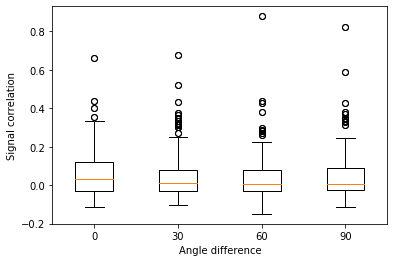

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=1)
data = []
for angle_dist, corrs in angle_dist_to_corrs.items():
    data.append(corrs)
ax.boxplot(data)
ax.set_xticklabels(['0', '30', '60', '90'])
ax.set_xlabel("Angle difference")
if corr_type == "TEMP_CORR_AVG":
    ax.set_ylabel("Signal correlation")
elif corr_type == "NOISE_CORR":
    ax.set_ylabel("Noise correlation")
#TODO: Just manually label the n's

for angle_dist, corrs in angle_dist_to_corrs.items():
    print(angle_dist, min(corrs), max(corrs), np.mean(corrs), np.std(corrs), len(corrs))

In [46]:
"""
Unused code that might be useful again someday
"""
"""
import seaborn as sns;
ser = pd.Series(list(dir_pairs_to_corrs.values()),
                  index=pd.MultiIndex.from_tuples(dir_pairs_to_corrs.keys()))
df = ser.unstack().fillna(0)
df = df.sort_index(axis=0 ,ascending=False)
sns.heatmap(df, center=0)

# For each angle, which angle groups are most correlated with it?
for dir1 in dirs:
    dir_partner_to_corr = {}
    for dir2 in dirs:
        key = (dir1, dir2)
        if key in dir_pairs_to_corrs:
            dir_partner_to_corr[dir2] = dir_pairs_to_corrs[key]
    desc_sorted_keys = sorted(dir_partner_to_corr, key=dir_partner_to_corr.get, reverse=True)
    print (dir1, desc_sorted_keys)
# The orderings are:
# For 501836392: [2,4,1,1,4,2,3], not bad, for a length of 8. mean ~2.43 ordering.
#   And.. that was when I was using allen dsi. When using our dsi, it got worse :(
# For 501886692: [6,5,7,2,2,3] - v bad
# For 501717543: [7,7,6,7,2] - v bad

"""
0

0